# RCM Task Extraction

### Import Libraries

In [1]:
import dask
from geocube.api.core import make_geocube
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib as pl
from pathlib import Path
from pyproj import CRS
import rasterio
from rasterio import mask
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from rasterio.plot import show
import rioxarray
import scipy
import shapely as sp
from shapely.geometry import Polygon
import sqlite3
import sys
import rioxarray
import xarray as xr

C:\Users\chrli\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Read Geopackage-Data

In [2]:
# Load Geopackage-Data (.gpkg)
geopackage_file = r"C:/Users/chrli/OneDrive/HiWi_RCM/Task1/_data/SG_4326_refDset.gpkg"
geopackage_data = gpd.read_file(geopackage_file)

### Calcualte resolution of polygons

In [3]:
# # Function to calculate side length of a polygon
# def calculate_polygon_side_length(polygon):
#     exterior_coords = list(polygon.exterior.coords)
#     side_length = max(abs(exterior_coords[0][0] - exterior_coords[1][0]),
#                       abs(exterior_coords[1][1] - exterior_coords[2][1]))
#     return side_length

# # Add new column with side lengths
# geopackage_data['side_length'] = geopackage_data['geometry'].apply(calculate_polygon_side_length)

# # Display the first few rows of the updated GeoDataFrame
# print(geopackage_data[['geometry', 'side_length']].head())

# # Side length is in decimal degrees
# decimal_degrees = 0.00009

# # WGS84: Rough estimate that 1 degree is approximately 111 kilometers
# approx_resolution_meters = decimal_degrees * 111000

# print(f"Genäherte Auflösung in Meter: {approx_resolution_meters} m")

### Read ZARR-Data

In [4]:
# Load Zarr file (.zarr)
zarr_file = Path(r"C:/Users/chrli/OneDrive/HiWi_RCM/Task1/_data/cube_4326_MRKN_10m_2017-2021_dB_pattern1D.zarr")

# Open Zarr file as xarray dataset
zarr_data = xr.open_zarr(zarr_file.as_posix())

### Prepare Zarr-Data
- set original crs WGS 84
- convert to float 32
- rechunk with dask
- convert crs to UTM32N

In [5]:
# set CRS using rioxarray
zarr_data.rio.set_crs('''GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]''')
print(zarr_data.rio.crs)

# Convert to float32
zarr_data = zarr_data.astype(np.float32)

# Select data for the year 2021
zarr_data_2021 = zarr_data.sel(time=slice('2021-03-01', '2021-09-01'))

# Rechunk the dataset along the 'time' dimension to new sizes
zarr_data_chunk_sizes = {'time': 80, 'lat': 100, 'lon': 100}
zarr_data_2021_rechunked = zarr_data_2021.chunk(zarr_data_chunk_sizes)
print(zarr_data_2021_rechunked.chunks)

# Set CRS to 32633
zarr_data_2021_rechunked_utm = zarr_data_2021_rechunked.rio.reproject("EPSG:32633")

# Print the CRS and chunk sizes of the rechunked dataset
print(zarr_data_2021_rechunked_utm.rio.crs)

zarr_data_2021_rechunked_utm

EPSG:4326
Frozen({'time': (80,), 'lat': (100, 100, 100, 100, 100, 100, 57), 'lon': (100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 70)})
EPSG:32633


<xarray.Dataset>
Dimensions:      (x: 937, y: 901, time: 80)
Coordinates:
  * x            (x) float64 3.061e+05 3.061e+05 ... 3.131e+05 3.131e+05
  * y            (y) float64 5.582e+06 5.582e+06 ... 5.575e+06 5.575e+06
  * time         (time) datetime64[ns] 2021-03-02T05:26:00 ... 2021-08-30T05:...
    spatial_ref  int32 0
Data variables:
    VH           (time, y, x) float32 3.403e+38 3.403e+38 ... 3.403e+38
    VV           (time, y, x) float32 3.403e+38 3.403e+38 ... 3.403e+38
    fid_mask     (y, x) float32 3.403e+38 3.403e+38 ... 3.403e+38 3.403e+38

### Save Zarr-Data

In [6]:
# Path to output folder
zarr_output_dir = r'C:\Users\chrli\OneDrive\HiWi_RCM\Task1\_data\cube_4326_MRKN_10m_2017-2021_dB_pattern1D_rechunked_utm.zarr'

# Check if the file already exists
if os.path.exists(zarr_output_dir):
    print("The file already exists.")
else:
    #Saving the result as a Zarr array in the output folder
    zarr_data_2021_rechunked_utm.to_zarr(zarr_output_dir)

The file already exists.


### Function: Create Dataframe with Layer information

In [7]:
def get_layer_names(geopackage_file):
    # Establish SQL connection
    sqliteConnection = sqlite3.connect(geopackage_file)
    cursor = sqliteConnection.cursor()

    # SQL query to list all tables in the geopackage that contain "_bare_soil" in their name
    cursor.execute("SELECT table_name FROM gpkg_contents WHERE data_type='features' AND table_name LIKE '%_bare_soil%';")
    tables_bare_soil_tuples = cursor.fetchall()

    # Convert the list of tuples to a list of strings
    tables_bare_soil = [table[0] for table in tables_bare_soil_tuples]

    # Create a list to store DataFrames
    dfs = []

    # Populate the list with DataFrames
    for table in tables_bare_soil:
        # Split the table name
        table_parts = table.split("_")

        # Extract information from layer names
        layer_name = "_".join(table_parts[:])
        crop_type_code = "_".join(table_parts[:1])
        sensor = "_".join(table_parts[1:2])
        AOI = "_".join(table_parts[2:3])
        fid = "_".join(table_parts[3:4])
        date = "_".join(table_parts[4:5])
        bbch = "_".join(table_parts[5:6])
        POI = "_".join(table_parts[6:])

        # Create a DataFrame with a single row
        # df = pd.DataFrame({"layer_name": [layer_name], "date": [date], "bbch": [bbch], "POI": [POI]})
        df = pd.DataFrame({"layer_name": [layer_name], "crop_type_code": [crop_type_code], "sensor": [sensor], "AOI": [AOI], "fid": [fid], "date": [date], "bbch": [bbch], "POI": [POI]})

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames in the list
    layer_names_df = pd.concat(dfs, ignore_index=True)

    # Close SQLite connection
    sqliteConnection.close()

    return layer_names_df

In [8]:
# Call function: get_layer_names
layer_names_df = get_layer_names(geopackage_file)
layer_names_df

,layer_name,crop_type_code,sensor,AOI,fid,date,bbch,POI
0,SG_CIR_MRKN_A2060-00_20210428_0_bare_soil,SG,CIR,MRKN,A2060-00,20210428,0,bare_soil
1,SG_CIR_MRKN_A2060-00_20210601_30_bare_soil,SG,CIR,MRKN,A2060-00,20210601,30,bare_soil
2,SG_CIR_MRKN_A2060-00_20210721_85_bare_soil,SG,CIR,MRKN,A2060-00,20210721,85,bare_soil
3,SG_CIR_MRKN_A2060-00_20210819_97_bare_soil,SG,CIR,MRKN,A2060-00,20210819,97,bare_soil


#### Function: Rasterize Geopackage with Geocube

In [9]:
output_layer_geopackages_dir = r"C:/Users/chrli/OneDrive/HiWi_RCM/Task1/_data/"

In [10]:
append = 'as_3_dimension'

def create_combined_geocube_data(layer_names_df, geopackage_file, output_layer_geopackages_dir, zarr_data_2021_rechunked_utm):
    # Create empty xarray
    combined_geocube_data = xr.Dataset()
    data_dict = {}
    # Read in the geopackages and save with a customized name
    for i, (index, row)  in enumerate(layer_names_df.iterrows()):
        layer_name = row['layer_name']
        date = row['date']
        bbch = row['bbch']
        poi = row['POI']


        # Saving the GeoDataFrame as a geopackage
        output_filename = f'geopackage_data_layer_{bbch}_{poi}.gpkg'
        output_path = os.path.join(output_layer_geopackages_dir, output_filename)
        layer_01 = gpd.read_file(geopackage_file, layer=layer_name)
        subset_layer_01 = layer_01

        geocube_data = make_geocube(vector_data=subset_layer_01, 
                                        measurements=["sum"],
                                        like=zarr_data_2021_rechunked_utm)

        geocube_data_plot = geocube_data['sum'].dropna(dim='x', how='all').dropna(dim='y', how='all').plot(figsize=(5,5))
        plt.title(output_filename)
        plt.show()

        data_dict[date] = geocube_data['sum'].isel(y=slice(None, None, -1)).isel(x=slice(None, -1, None))
    


    if append == 'as_3_dimension':

        # Convert the dictionary to an xarray dataset
        combined_geocube_data = xr.Dataset(data_dict)

        # Convert the dictionary values to a list
        data_arrays = list(data_dict.values())

        # Concatenate along the time dimension
        combined_geocube_data = xr.concat(data_arrays, dim='time')

        # Assign the time values from the dictionary keys
        combined_geocube_data['time'] = list(data_dict.keys())


        # this one returnce different array size!!!

        # Create a Dask-backed xarray Dataset
        #combined_geocube_data = xr.Dataset({
        #    'time': list(data_dict.keys()),
        #    'data': (['time', 'y', 'x'], [dask.array.from_array(da.values, chunks="auto") for da in data_dict.values()])
        #})

           # Ensure 'x' and 'y' coordinates match with 'other_dataset'
        #combined_geocube_data['x'] = other_dataset['x']
        #combined_geocube_data['y'] = other_dataset['y']



    elif append == 'as_variable':
        # Convert the dictionary to an xarray dataset
        combined_geocube_data = xr.Dataset(data_dict)

    return combined_geocube_data
    # combined_geocube_data

    # Print the resulting dataset
    #print(combined_geocube_data)

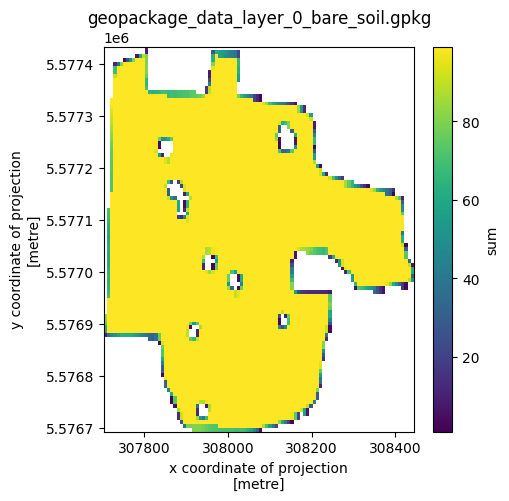

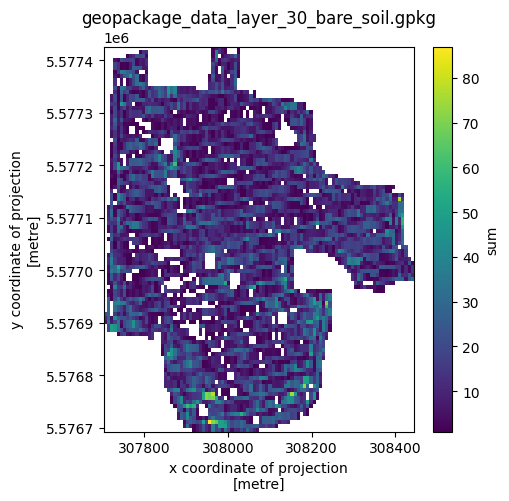

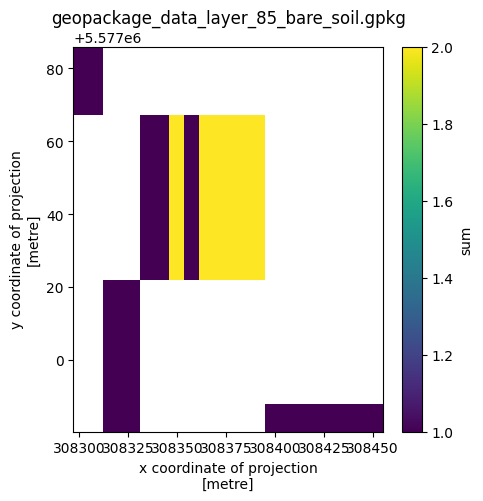

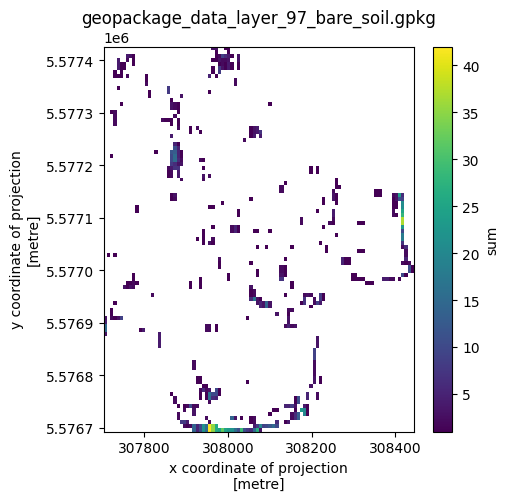

C:\Users\chrli\anaconda3\lib\site-packages\xarray\core\concat.py:504: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.DataArray 'sum' (time: 4, y: 901, x: 936)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 5.575e+06 5.575e+06 ... 5.582e+06 5.582e+06
  * x            (x) float64 3.061e+05 3.061e+05 ... 3.131e+05 3.131e+05
    spatial_ref  int32 0
  * time         (time) <U8 '20210428' '20210601' '20210721' '20210819'
Attributes:
    name:        sum
    long_name:   sum
    _FillValue:  nan

In [11]:
# Call function: create_combined_geocube_data
combined_geocube_data = create_combined_geocube_data(layer_names_df, geopackage_file, output_layer_geopackages_dir, zarr_data_2021_rechunked_utm)
combined_geocube_data

### Change Xarray Attributes

- rename "name"
- delete "_FillValue"
- delete "long_name"

In [12]:
attributes = combined_geocube_data.attrs

# Change Attributes
print(f"\nOld Attributes:")
for key, value in attributes.items():
    print(f"{key}: {value}")

print("\nChanges:")
try:
    # Change the attribute name
    combined_geocube_data.attrs['name'] = 'mask'
    
    print("\"name\" renamed.")
except KeyError:
    print("\"name\" not found.")
    
try:   
    # Delete the "_FillValue" attribute
    del combined_geocube_data.attrs['_FillValue']
        
    print("\"_FillValue\" deleted.")
except KeyError:
    print("\"_FillValue\" not found.")
    
try:    
    # Delete the "_FillValue" attribute
    del combined_geocube_data.attrs['long_name']
    
    print("\"long_name\"  deleted.")
except KeyError:
    print("\"long_name\" not found.")

# Show the attributes of combined_geocube_data
attributes = combined_geocube_data.attrs

# Print the attributes
print(f"\nNew Attributes:")
for key, value in attributes.items():
    print(f"{key}: {value}")


Old Attributes:
name: sum
long_name: sum
_FillValue: nan

Changes:
"name" renamed.
"_FillValue" deleted.
"long_name"  deleted.

New Attributes:
name: mask


In [13]:
combined_geocube_data

<xarray.DataArray 'sum' (time: 4, y: 901, x: 936)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 5.575e+06 5.575e+06 ... 5.582e+06 5.582e+06
  * x            (x) float64 3.061e+05 3.061e+05 ... 3.131e+05 3.131e+05
    spatial_ref  int32 0
  * time         (time) <U8 '20210428' '20210601' '20210721' '20210819'
Attributes:
    name:     mask

### Rechunk combined_geocube_data

In [14]:
# Rechunk the dataset along the 'time' dimension to new sizes
combined_geocube_data_chunk_sizes = {'time': 4, 'x': 200, 'y': 200}
combined_geocube_data_rechunked = combined_geocube_data.chunk(combined_geocube_data_chunk_sizes)

# Print the CRS and chunk sizes of the rechunked dataset
print(combined_geocube_data_rechunked.rio.crs)
print(combined_geocube_data_rechunked.chunks)

combined_geocube_data_rechunked

EPSG:32633
((4,), (200, 200, 200, 200, 101), (200, 200, 200, 200, 136))


<xarray.DataArray 'sum' (time: 4, y: 901, x: 936)>
dask.array<xarray-<this-array>, shape=(4, 901, 936), dtype=float64, chunksize=(4, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.575e+06 5.575e+06 ... 5.582e+06 5.582e+06
  * x            (x) float64 3.061e+05 3.061e+05 ... 3.131e+05 3.131e+05
    spatial_ref  int32 0
  * time         (time) <U8 '20210428' '20210601' '20210721' '20210819'
Attributes:
    name:     mask

### Median over Time

C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


<xarray.DataArray 'sum' (time: 4, y: 98, x: 98)>
dask.array<getitem, shape=(4, 98, 98), dtype=float64, chunksize=(4, 98, 98), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.577e+06 5.577e+06 ... 5.577e+06 5.577e+06
  * x            (x) float64 3.077e+05 3.077e+05 ... 3.084e+05 3.084e+05
    spatial_ref  int32 0
  * time         (time) <U8 '20210428' '20210601' '20210721' '20210819'
    median       (y, x) float64 dask.array<chunksize=(98, 98), meta=np.ndarray>
Attributes:
    name:     mask

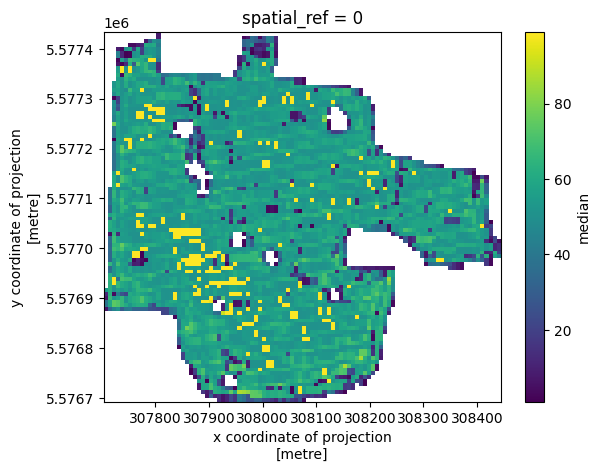

In [15]:
# Median over "time"
combined_geocube_data_rechunked["median"] = combined_geocube_data_rechunked.median(dim="time")

# Drop NaN values along the 'x' and 'y' dimensions
mask_median = combined_geocube_data_rechunked["median"].dropna(dim='x', how='all').dropna(dim='y', how='all')

# Reduce the coordinates
combined_geocube_data_rechunked_reduced = combined_geocube_data_rechunked.sel(x=mask_median.x, y=mask_median.y)

combined_geocube_data_rechunked_reduced["median"].plot()
combined_geocube_data_rechunked_reduced

### Create Masks

C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


<xarray.DataArray 'sum' (time: 4, y: 98, x: 98)>
dask.array<getitem, shape=(4, 98, 98), dtype=float64, chunksize=(4, 98, 98), chunktype=numpy.ndarray>
Coordinates:
  * y                  (y) float64 5.577e+06 5.577e+06 ... 5.577e+06 5.577e+06
  * x                  (x) float64 3.077e+05 3.077e+05 ... 3.084e+05 3.084e+05
    spatial_ref        int32 0
  * time               (time) <U8 '20210428' '20210601' '20210721' '20210819'
    median             (y, x) float64 dask.array<chunksize=(98, 98), meta=np.ndarray>
    mask_median_10_30  (y, x) float64 dask.array<chunksize=(98, 98), meta=np.ndarray>
Attributes:
    name:     mask

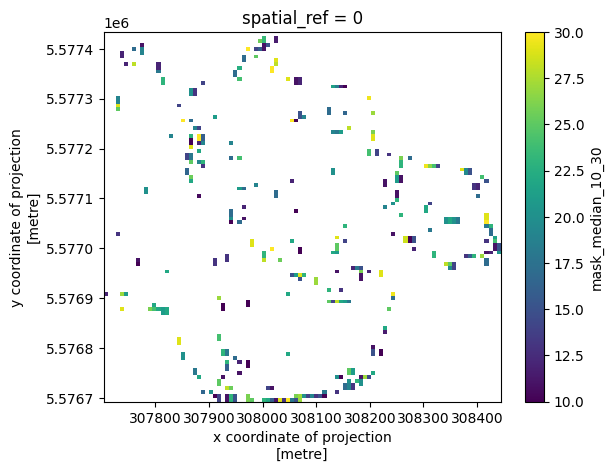

In [16]:
# Define the range
range_min = 10
range_max = 30

# Create the new mask within the range
combined_geocube_data_rechunked_reduced[f"mask_median_{range_min}_{range_max}"] = combined_geocube_data_rechunked_reduced["median"].where((combined_geocube_data_rechunked_reduced["median"] >= range_min) & (combined_geocube_data_rechunked_reduced["median"] <= range_max), float("nan"))

# Plot the new mask
combined_geocube_data_rechunked_reduced[f"mask_median_{range_min}_{range_max}"].plot()

# Display the modified xarray
combined_geocube_data_rechunked_reduced

### Delete individual masks

In [17]:
# # delete individual masks
# del_range_min = 40
# del_range_max = 60

# del combined_geocube_data_rechunked_reduced[f"mask_median_{del_range_min}_{del_range_max}"]

### Select a mask based on Feature ID

Feature ID (fid) 534 refers to one of the observed fields.

In [18]:
# Find unique Feature ID values
unique_fid_values = zarr_data_2021['fid_mask'].values.flatten()

# Remove any NaN values from the array
unique_fid_values = unique_fid_values[~np.isnan(unique_fid_values)]

# Get the unique values from the array
unique_fid_values = np.unique(unique_fid_values)

# Convert the values in unique_fid_values to integers
unique_fid_values = unique_fid_values.astype(int)

print("Eindeutige FID-Werte:", unique_fid_values)

Eindeutige FID-Werte: [360 362 377 380 382 534 537 540 541 563 589 591]


In [19]:
# Select Feature ID
fid_index = 5
fid = unique_fid_values[fid_index]

# Create mask for fid
zarr_data_2021_rechunked_utm_534 = zarr_data_2021_rechunked_utm.where(zarr_data_2021_rechunked_utm[f"fid_mask"] == fid, drop=True)

# Rename the data variable
zarr_data_2021_rechunked_utm_534 = zarr_data_2021_rechunked_utm_534.rename_vars({"fid_mask": f"fid_mask_{fid}"})

#data=data_full
zarr_data_2021_rechunked_utm_534

<xarray.Dataset>
Dimensions:       (time: 80, y: 96, x: 97)
Coordinates:
  * x             (x) float64 3.077e+05 3.077e+05 ... 3.084e+05 3.084e+05
  * y             (y) float64 5.577e+06 5.577e+06 ... 5.577e+06 5.577e+06
  * time          (time) datetime64[ns] 2021-03-02T05:26:00 ... 2021-08-30T05...
    spatial_ref   int32 0
Data variables:
    VH            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    VV            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    fid_mask_534  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

### Plot of VV and VH at one point in time

In [20]:
# # Create a figure with two subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# # Plot the first data in the first subplot
# zarr_data_2021_rechunked_utm_534.VV.isel(time=1).plot(ax=axs[0])
# axs[0].set_title('zarr_data_rechunked_utm_2021_534.VH.isel(time=1)\n')

# # Plot the second data in the second subplot
# zarr_data_2021_rechunked_utm_534.VH.isel(time=1).plot(ax=axs[1])
# axs[1].set_title('zarr_data_rechunked_utm_2021_534.VV.isel(time=1)\n')

# # Adjust the layout
# plt.tight_layout()

# plt.show()

### Plot Mean over time of VV and VH

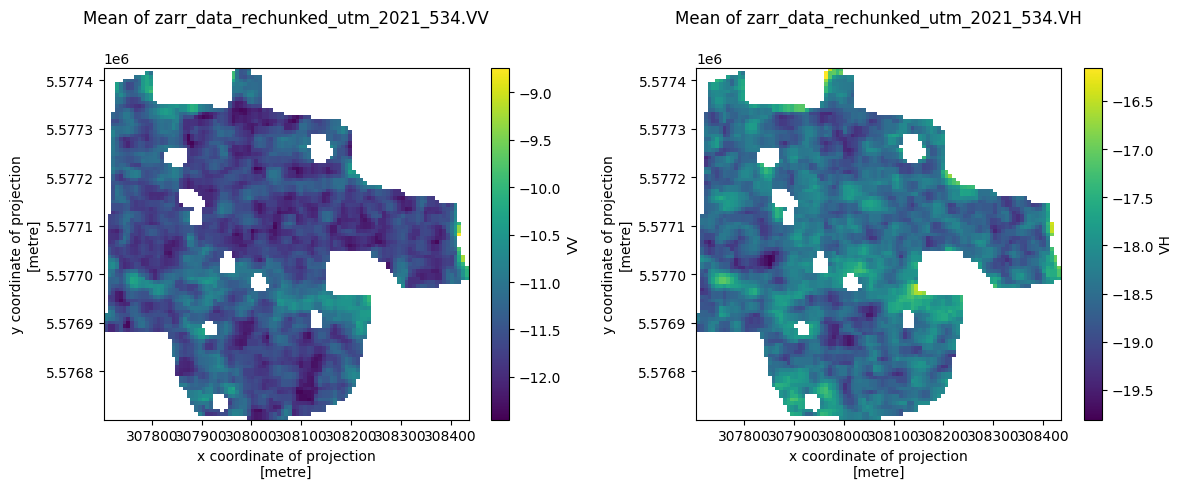

In [21]:
# Calculate the mean over the entire time span for each data array
zarr_data_2021_rechunked_utm_534_mean_VV = zarr_data_2021_rechunked_utm_534.VV.mean(dim='time')
zarr_data_2021_rechunked_utm_534_mean_VH = zarr_data_2021_rechunked_utm_534.VH.mean(dim='time')

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the mean of the first data in the first subplot
zarr_data_2021_rechunked_utm_534_mean_VV.plot(ax=axs[0])
axs[0].set_title('Mean of zarr_data_rechunked_utm_2021_534.VV\n')

# Plot the mean of the second data in the second subplot
zarr_data_2021_rechunked_utm_534_mean_VH.plot(ax=axs[1])
axs[1].set_title('Mean of zarr_data_rechunked_utm_2021_534.VH\n')

# Adjust the layout
plt.tight_layout()

plt.show()

### Plot masked Zarr-Data

In [22]:
# Get all coordinates of combined_geocube_data_rechunked_reduced
all_coords = combined_geocube_data_rechunked_reduced.coords

# Filter coordinates that include "mask" in their name
mask_coords = [coord_name for coord_name in all_coords if 'mask' in coord_name]

# Create a list with all coord_name values
masks_list = [coord_name for coord_name in mask_coords]

# Print the filtered coordinates
print("Masks:")
print(masks_list)

Masks:
['mask_median_10_30']


C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


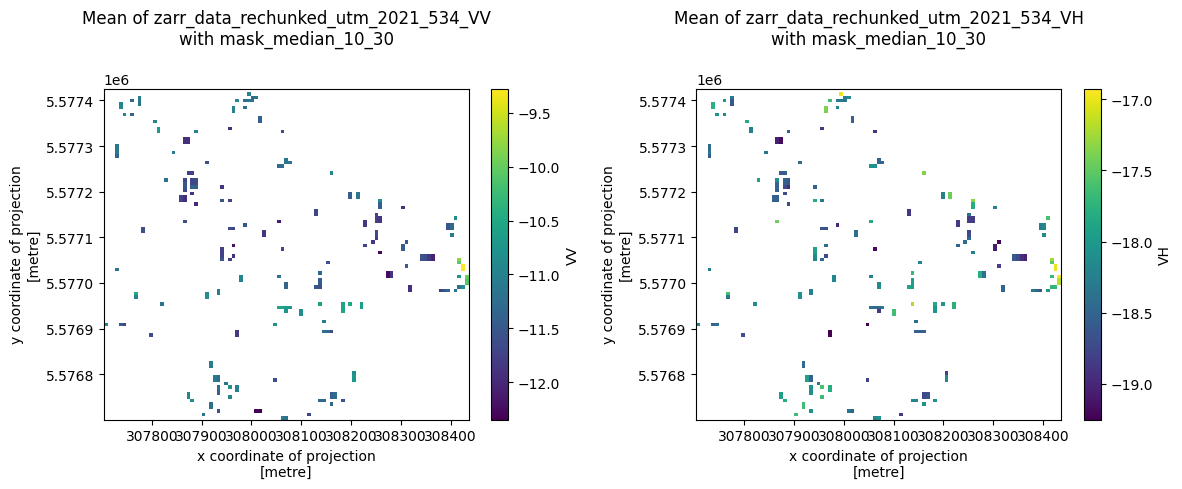

In [23]:
mask_index = 0
current_mask = masks_list[mask_index]

# Calculate the mean over the entire time span for each data array
zarr_data_2021_rechunked_utm_534_mean_VV = zarr_data_2021_rechunked_utm_534.VV.mean(dim='time')
zarr_data_2021_rechunked_utm_534_mean_VH = zarr_data_2021_rechunked_utm_534.VH.mean(dim='time')

# Filter Zarr Data Variables based on NaN values in combined_geocube_data_rechunked_reduced
filtered_zarr_data_2021_rechunked_utm_534_mean_VV = zarr_data_2021_rechunked_utm_534_mean_VV.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))
filtered_zarr_data_2021_rechunked_utm_534_mean_VH = zarr_data_2021_rechunked_utm_534_mean_VH.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the mean of the first data in the first subplot
filtered_zarr_data_2021_rechunked_utm_534_mean_VV.plot(ax=axs[0])
axs[0].set_title(f"Mean of zarr_data_rechunked_utm_2021_534_VV\nwith {current_mask}\n")

# Plot the mean of the second data in the second subplot
filtered_zarr_data_2021_rechunked_utm_534_mean_VH.plot(ax=axs[1])
axs[1].set_title(f"Mean of zarr_data_rechunked_utm_2021_534_VH\nwith {current_mask}\n")

# Adjust the layout
plt.tight_layout()

plt.show()

### Plot Time Series for masked and full Zarr-Data

C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


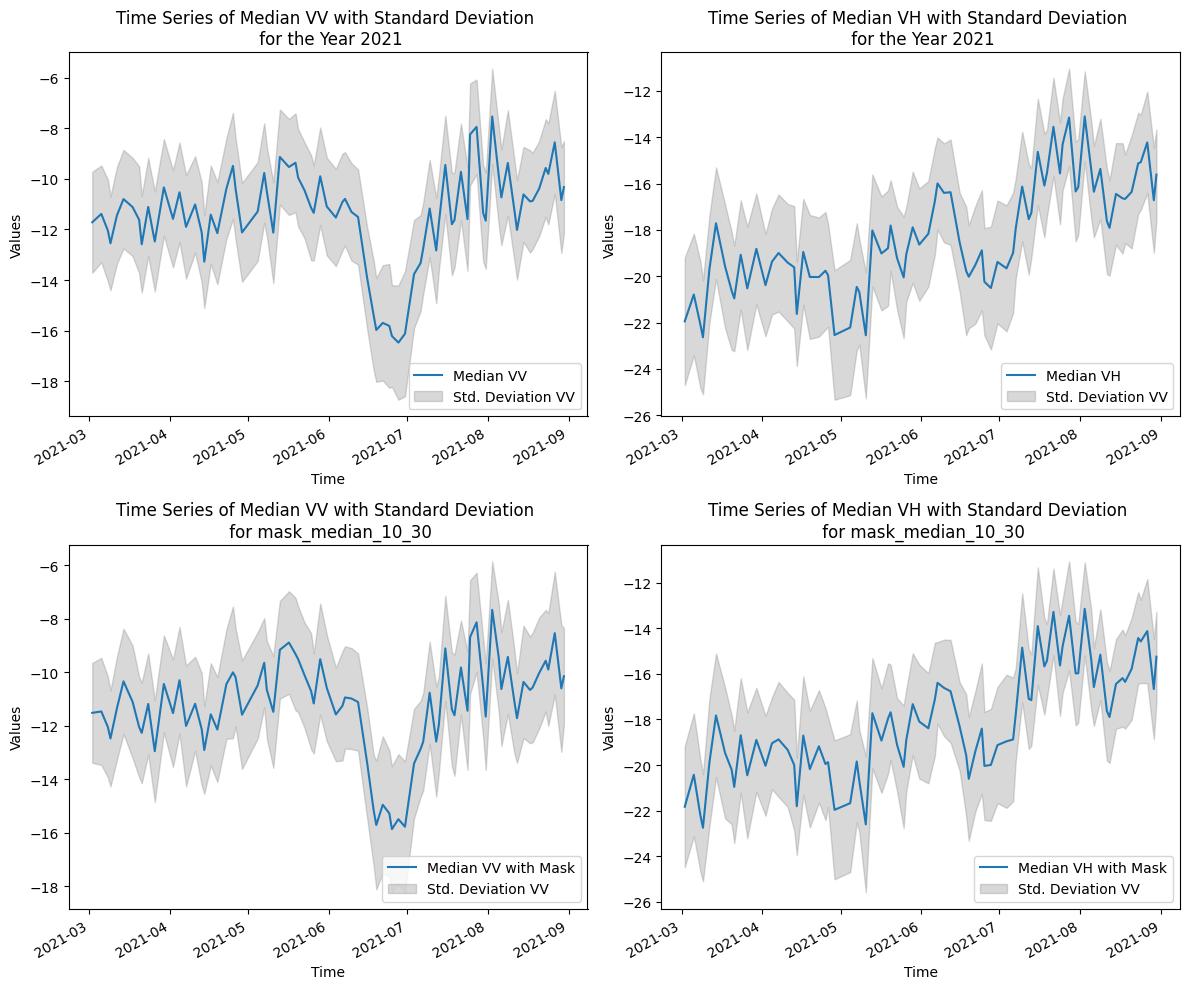

In [24]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Calculate the median and standard deviation over the spatial dimensions (x,y) for VV
median_profile_vv = zarr_data_2021_rechunked_utm_534["VV"].median(dim=("x", "y"))
std_dev_profile_vv = zarr_data_2021_rechunked_utm_534["VV"].std(dim=("x", "y"))

# Plot the median line for VV
median_line_vv = median_profile_vv.plot(ax=axes[0, 0], label="Median VV")

# Plot the shaded region for the standard deviation of VV
axes[0, 0].fill_between(
    median_profile_vv["time"].values,
    (median_profile_vv - std_dev_profile_vv).values,
    (median_profile_vv + std_dev_profile_vv).values,
    color="gray",
    alpha=0.3,
    label="Std. Deviation VV"
)

# Add axis labels and a title for VV subplot
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Values")
axes[0, 0].set_title("Time Series of Median VV with Standard Deviation \n for the Year 2021")

# Calculate the median and standard deviation over the spatial dimensions (x,y) for VH
median_profile_vh = zarr_data_2021_rechunked_utm_534["VH"].median(dim=("x", "y"))
std_dev_profile_vh = zarr_data_2021_rechunked_utm_534["VH"].std(dim=("x", "y"))

# Plot the median line for VH
median_line_vh = median_profile_vh.plot(ax=axes[0, 1], label="Median VH")

# Plot the shaded region for the standard deviation of VH
axes[0, 1].fill_between(
    median_profile_vh["time"].values,
    (median_profile_vh - std_dev_profile_vh).values,
    (median_profile_vh + std_dev_profile_vh).values,
    color="gray",
    alpha=0.3,
    label="Std. Deviation VV"
)

# Add axis labels and a title for VH subplot
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Values")
axes[0, 1].set_title("Time Series of Median VH with Standard Deviation \n for the Year 2021")

# Calculate the median and standard deviation over the spatial dimensions (x,y) for VV with current mask
median_profile_vv_masked = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))["VV"].median(dim=("x", "y"))
std_dev_profile_vv_masked = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))["VV"].std(dim=("x", "y"))

# Plot the median line for VV with current mask
median_line_vv_masked = median_profile_vv_masked.plot(ax=axes[1, 0], label="Median VV with Mask")

# Plot the shaded region for the standard deviation of VV with current mask
axes[1, 0].fill_between(
    median_profile_vv_masked["time"].values,
    (median_profile_vv_masked - std_dev_profile_vv_masked).values,
    (median_profile_vv_masked + std_dev_profile_vv_masked).values,
    color="gray",
    alpha=0.3,
    label="Std. Deviation VV"
)

# Add axis labels and a title for VV with current mask subplot
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Values")
axes[1, 0].set_title(f"Time Series of Median VV with Standard Deviation \n for {current_mask}")

# Calculate the median and standard deviation over the spatial dimensions (x,y) for VH with current mask
median_profile_vh_masked = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))["VH"].median(dim=("x", "y"))
std_dev_profile_vh_masked = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))["VH"].std(dim=("x", "y"))

# Plot the median line for VH with current mask
median_line_vh_masked = median_profile_vh_masked.plot(ax=axes[1, 1], label="Median VH with Mask")

# Plot the shaded region for the standard deviation of VH with current mask
axes[1, 1].fill_between(
    median_profile_vh_masked["time"].values,
    (median_profile_vh_masked - std_dev_profile_vh_masked).values,
    (median_profile_vh_masked + std_dev_profile_vh_masked).values,
    color="gray",
    alpha=0.3,
    label="Std. Deviation VV"
)

# Add axis labels and a title for VH with current mask subplot
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Values")
axes[1, 1].set_title(f"Time Series of Median VH with Standard Deviation \n for {current_mask}")

# Move the legend to the lower right corner for all subplots
axes[0, 0].legend(loc="lower right")
axes[0, 1].legend(loc="lower right")
axes[1, 0].legend(loc="lower right")
axes[1, 1].legend(loc="lower right")

# Adjust layout
plt.tight_layout()

plt.show()

### Plot SMOTHED Time Series for masked and full Zarr-Data

C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\chrli\anaconda3\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


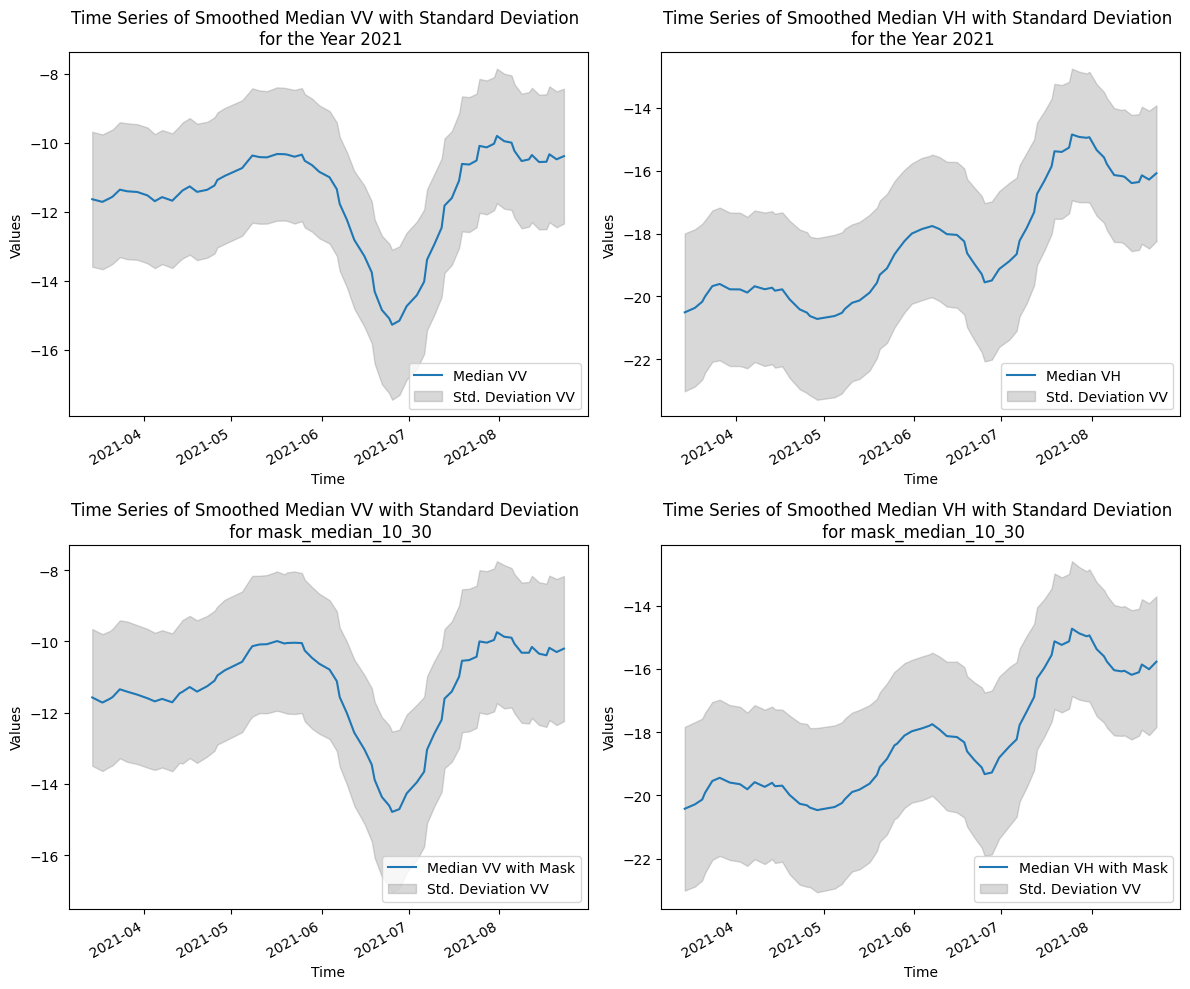

In [28]:
# set smoothing window
smoothing_window = 10

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Calculate the median and standard deviation over the spatial dimensions (x,y) for VV
median_profile_vv = zarr_data_2021_rechunked_utm_534["VV"].median(dim=("x", "y"))
std_dev_profile_vv = zarr_data_2021_rechunked_utm_534["VV"].std(dim=("x", "y"))

# Smooth the median and standard deviation profiles for VV
median_profile_vv_smoothed = median_profile_vv.rolling(time=smoothing_window, center=True).mean()
std_dev_profile_vv_smoothed = std_dev_profile_vv.rolling(time=smoothing_window, center=True).mean()

# Plot the smoothed median line for VV
median_line_vv = median_profile_vv_smoothed.plot(ax=axes[0, 0], label="Median VV")

# Plot the shaded region for the smoothed standard deviation of VV
axes[0, 0].fill_between(
    median_profile_vv_smoothed["time"].values,
    (median_profile_vv_smoothed - std_dev_profile_vv_smoothed).values,
    (median_profile_vv_smoothed + std_dev_profile_vv_smoothed).values,
    color="gray",
    alpha=0.3,
    label="Std. Deviation VV"
)

# Add axis labels and a title for VV subplot
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Values")
axes[0, 0].set_title("Time Series of Smoothed Median VV with Standard Deviation \n for the Year 2021")

# Calculate the median and standard deviation over the spatial dimensions (x,y) for VH
median_profile_vh = zarr_data_2021_rechunked_utm_534["VH"].median(dim=("x", "y"))
std_dev_profile_vh = zarr_data_2021_rechunked_utm_534["VH"].std(dim=("x", "y"))

# Smooth the median and standard deviation profiles for VH
median_profile_vh_smoothed = median_profile_vh.rolling(time=smoothing_window, center=True).mean()
std_dev_profile_vh_smoothed = std_dev_profile_vh.rolling(time=smoothing_window, center=True).mean()

# Plot the smoothed median line for VH
median_line_vh = median_profile_vh_smoothed.plot(ax=axes[0, 1], label="Median VH")

# Plot the shaded region for the smoothed standard deviation of VH
axes[0, 1].fill_between(
    median_profile_vh_smoothed["time"].values,
    (median_profile_vh_smoothed - std_dev_profile_vh_smoothed).values,
    (median_profile_vh_smoothed + std_dev_profile_vh_smoothed).values,
    color="gray",
    alpha=0.3,
    label="Std. Deviation VV"
)

# Add axis labels and a title for VH subplot
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Values")
axes[0, 1].set_title("Time Series of Smoothed Median VH with Standard Deviation \n for the Year 2021")

# Calculate the median and standard deviation over the spatial dimensions (x,y) for VV with current mask
median_profile_vv_masked = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))["VV"].median(dim=("x", "y"))
std_dev_profile_vv_masked = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))["VV"].std(dim=("x", "y"))

# Smooth the median and standard deviation profiles for VV with current mask
median_profile_vv_masked_smoothed = median_profile_vv_masked.rolling(time=smoothing_window, center=True).mean()
std_dev_profile_vv_masked_smoothed = std_dev_profile_vv_masked.rolling(time=smoothing_window, center=True).mean()

# Plot the smoothed median line for VV with current mask
median_line_vv_masked = median_profile_vv_masked_smoothed.plot(ax=axes[1, 0], label="Median VV with Mask")

# Plot the shaded region for the smoothed standard deviation of VV with current mask
axes[1, 0].fill_between(
    median_profile_vv_masked_smoothed["time"].values,
    (median_profile_vv_masked_smoothed - std_dev_profile_vv_masked_smoothed).values,
    (median_profile_vv_masked_smoothed + std_dev_profile_vv_masked_smoothed).values,
    color="gray",
    alpha=0.3,
    label="Std. Deviation VV"
)

# Add axis labels and a title for VV with current mask subplot
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Values")
axes[1, 0].set_title(f"Time Series of Smoothed Median VV with Standard Deviation \n for {current_mask}")

# Calculate the median and standard deviation over the spatial dimensions (x,y) for VH with current mask
median_profile_vh_masked = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))["VH"].median(dim=("x", "y"))
std_dev_profile_vh_masked = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))["VH"].std(dim=("x", "y"))

# Smooth the median and standard deviation profiles for VH with current mask
median_profile_vh_masked_smoothed = median_profile_vh_masked.rolling(time=smoothing_window, center=True).mean()
std_dev_profile_vh_masked_smoothed = std_dev_profile_vh_masked.rolling(time=smoothing_window, center=True).mean()

# Plot the smoothed median line for VH with current mask
median_line_vh_masked = median_profile_vh_masked_smoothed.plot(ax=axes[1, 1], label="Median VH with Mask")

# Plot the shaded region for the smoothed standard deviation of VH with current mask
axes[1, 1].fill_between(
    median_profile_vh_masked_smoothed["time"].values,
    (median_profile_vh_masked_smoothed - std_dev_profile_vh_masked_smoothed).values,
    (median_profile_vh_masked_smoothed + std_dev_profile_vh_masked_smoothed).values,
    color="gray",
    alpha=0.3,
    label="Std. Deviation VV"
)

# Add axis labels and a title for VH with current mask subplot
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Values")
axes[1, 1].set_title(f"Time Series of Smoothed Median VH with Standard Deviation \n for {current_mask}")

# Move the legend to the lower right corner for all subplots
axes[0, 0].legend(loc="lower right")
axes[0, 1].legend(loc="lower right")
axes[1, 0].legend(loc="lower right")
axes[1, 1].legend(loc="lower right")

# Adjust layout
plt.tight_layout()

plt.show()

### Plot Timer Series for Zarr-Data

In [26]:
# # Create subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# # Calculate the median and standard deviation over the spatial dimensions (x,y) for VV
# median_profile_vv = zarr_data_2021_rechunked_utm_534["VV"].median(dim=("x", "y"))
# std_dev_profile_vv = zarr_data_2021_rechunked_utm_534["VV"].std(dim=("x", "y"))

# # Plot the median line for VV
# median_line_vv = median_profile_vv.plot(ax=ax1, label="Median VV")

# # Plot the shaded region for the standard deviation of VV
# ax1.fill_between(
#     median_profile_vv["time"].values,
#     (median_profile_vv - std_dev_profile_vv).values,
#     (median_profile_vv + std_dev_profile_vv).values,
#     color="gray",
#     alpha=0.3,
#     label="Std. Deviation VV"
# )

# # Add axis labels and a title for VV subplot
# ax1.set_xlabel("Time")
# ax1.set_ylabel("Values")
# ax1.set_title("Time Series of Median VV with Standard Deviation for the Year 2021")

# # Calculate the median and standard deviation over the spatial dimensions (x,y) for VH
# median_profile_vh = zarr_data_2021_rechunked_utm_534["VH"].median(dim=("x", "y"))
# std_dev_profile_vh = zarr_data_2021_rechunked_utm_534["VH"].std(dim=("x", "y"))

# # Plot the median line for VH
# median_line_vh = median_profile_vh.plot(ax=ax2, label="Median VH")

# # Plot the shaded region for the standard deviation of VH
# ax2.fill_between(
#     median_profile_vh["time"].values,
#     (median_profile_vh - std_dev_profile_vh).values,
#     (median_profile_vh + std_dev_profile_vh).values,
#     color="gray",
#     alpha=0.3,
#     label="Std. Deviation VH"
# )

# # Add axis labels and a title for VH subplot
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Values")
# ax2.set_title("Time Series of Median VH with Standard Deviation for the Year 2021")

# # Move the legend to the lower right corner for both subplots
# ax1.legend(loc="lower right")
# ax2.legend(loc="lower right")

# # Adjust layout
# plt.tight_layout()

# plt.show()

### Plot Time Series for mask

In [27]:
# # Create subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# # Calculate the median and standard deviation over the spatial dimensions (x,y) for VV
# median_profile_vv = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))
# median_profile_vv = median_profile_vv["VV"].median(dim=("x", "y"))

# std_dev_profile_vv = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))
# std_dev_profile_vv = std_dev_profile_vv["VV"].std(dim=("x", "y"))

# # Plot the median line for VV
# median_line_vv = median_profile_vv.plot(ax=ax1, label="Median VV")

# # Plot the shaded region for the standard deviation of VV
# ax1.fill_between(
#     median_profile_vv["time"].values,
#     (median_profile_vv - std_dev_profile_vv).values,
#     (median_profile_vv + std_dev_profile_vv).values,
#     color="gray",
#     alpha=0.3,
#     label="Std. Deviation VV"
# )

# # Add axis labels and a title for VV subplot
# ax1.set_xlabel("Time")
# ax1.set_ylabel("Values")
# ax1.set_title(f"Time Series of Median VV with Standard Deviation \n for {current_mask}")

# # Calculate the median and standard deviation over the spatial dimensions (x,y) for VH
# median_profile_vh = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))
# median_profile_vh = median_profile_vh["VH"].median(dim=("x", "y"))

# std_dev_profile_vh = zarr_data_2021_rechunked_utm_534.where(~np.isnan(combined_geocube_data_rechunked_reduced["{}".format(current_mask)]))
# std_dev_profile_vh = std_dev_profile_vh["VH"].std(dim=("x", "y"))

# # Plot the median line for VH
# median_line_vh = median_profile_vh.plot(ax=ax2, label="Median VH")

# # Plot the shaded region for the standard deviation of VH
# ax2.fill_between(
#     median_profile_vh["time"].values,
#     (median_profile_vh - std_dev_profile_vh).values,
#     (median_profile_vh + std_dev_profile_vh).values,
#     color="gray",
#     alpha=0.3,
#     label="Std. Deviation VH"
# )

# # Add axis labels and a title for VH subplot
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Values")
# ax2.set_title(f"Time Series of Median VH with Standard Deviation \n for {current_mask}")

# # Move the legend to the lower right corner for both subplots
# ax1.legend(loc="lower right")
# ax2.legend(loc="lower right")

# # Adjust layout
# plt.tight_layout()

# plt.show()